# Notebook to reproduce your ensembling results on Erica's data. 

We need to run this notebook on a GPU instance because otherwise it takes too long to create the median detections. 

In [6]:
import dgp_ensembletools.models
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import joblib 
import os
from moviepy.editor import VideoFileClip
#dgp_ensembletools.models.memory = joblib.Memory(os.path.join(os.getenv("HOME"),"ensembledata_2","cache"))

In [7]:
dgp_ensembletools.models
datapath = "~/ensembledata_3/"

## Next Todos: 
- add in a vert line to show where the example frame is from. 
- look into location refinement. 
- change legend colors to match between example frame and here. done 
- make legend bigger done 
- make video. done 


## Incorporate RMSE code. 

Here's code to get the example frames: 

In [8]:
import deeplabcut.utils.auxiliaryfunctions as auxiliaryfunctions
from deepgraphpose.models.eval import load_pose_from_dlc_to_dict
from deepgraphpose.utils_model import get_train_config
from pathlib import Path
import os
from deepgraphpose.models.fitdgp_util import get_snapshot_path
import pandas as pd

In [9]:
num_trains = 5
num_seeds = 9
#training_subsets = np.round(np.linspace(0.1,0.9, num_trains), 2)
training_subsets = {""}
training_seed = np.arange(1, num_seeds+1).astype('int')
ensemblepaths = {20:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results",
                 40:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_40p_real/process_results",
                 60:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results",
                 80:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results",
                 100:"/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_100p_real/process_results"}
# ensemblepaths = {10:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results",
#                  30:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_30p_real/process_results",
#                  50:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_50p_real/process_results",
#                  70:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_70p_real/process_results",
#                  90:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_20_90p_real/"}
#%%
train_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
test_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
train_error_ensemble = np.zeros((num_trains,))*np.nan
test_error_ensemble = np.zeros((num_trains,))*np.nan
epsilon = 0
#nc = 200
ws_flag = None
#%%
task="B29_post_side_15"
scorer="erica"
data_directory = "/home/ubuntu/ensembledata_3/"
training_subsets = {"job__ensemble-dgp_3_14_20p_real":20}


video_folder = ""
traces_folder = "videos_pred/{}_labeled.csv".format(task)
heatmaps_folder = "videos_pred/{}_labeled.npy".format(task)
shuffle=1
trainingsetindex=0
#%%
train_indices = [[]]*num_trains
test_indices = [[]]*num_trains
heatmap_indices = [[]]*num_trains
train_indices = {}
test_indices = {}
heatmap_indices = {}
skipped_seed = [[]]*num_trains
for train_fraction,ensemblepath in ensemblepaths.items():
    print("\n\n{}".format(train_fraction))
    heatmaps_files = []
    train_frames_ensemble = []
    test_frames_ensemble = []
    for seed_idx, seed in enumerate(training_seed):
        #date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}".format(ensemblepath)/"{}".format(seed))
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        cfg["project_path"] = os.path.join(data_directory,ensemblepath,str(seed))
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            skipped_seed[date_idx].append(seed_idx)
            continue
        # ------
        # get train/test sets (indices for video)
        trainingsetfolder = auxiliaryfunctions.GetTrainingSetFolder(cfg)
        datafn, metadatafn = auxiliaryfunctions.GetDataandMetaDataFilenames(
            trainingsetfolder, cfg['TrainingFraction'][trainingsetindex], shuffle, cfg)
        # Load meta data
        data, trainIndices, testIndices, trainFraction = auxiliaryfunctions.LoadMetadata(
            os.path.join(data_directory,ensemblepath,str(seed), metadatafn))
        # the train indices are the indices of the labeled frames? or the video itself
        # they are of the training set, so read the indices of the video
        Data = pd.read_hdf(os.path.join(data_directory,ensemblepath,str(seed), str(trainingsetfolder),
                                        'CollectedData_' + cfg["scorer"] + '.h5'),
                           'df_with_missing') #* dlc_cfg['global_scale']
        num_labels, _ = Data.values.shape
        labeled_frames = np.empty(num_labels).astype('int')
        for frame_idx in range(num_labels):
            idx_name = int(Path(Data.iloc[frame_idx].name).stem[3:])
            labeled_frames[frame_idx] = idx_name
        # Video frames user for training and testing:
        train_frames = labeled_frames[trainIndices]
        test_frames = labeled_frames[testIndices]
        # --- store confidence map to then calculate ensemble from heatmaps
        #last_snapshot, snapshot_data = get_last_snapshot(cfg_folder)
        last_snapshot = "snapshot-step2-final--0"
        assert "step2-final"  in last_snapshot
        print(cfg_folder.rsplit("/", 1)[-1], last_snapshot)
        # continue
        snapshot_path, cfg_yaml = get_snapshot_path(last_snapshot, cfg_folder,
                                                    shuffle=shuffle)
        #cfg = auxiliaryfunctions.read_config(cfg_yaml)
        video_file = Path(cfg_folder) / "videos/{}.mp4".format(task)
        video_pred_path = str(Path(cfg_folder) / 'videos_pred')
        print(snapshot_path)
#         _ = estimate_pose(
#                  proj_cfg_file=str(cfg_yaml),
#                  dgp_model_file=str(snapshot_path),
#                  video_file=str(video_file),
#                  output_dir=str(video_pred_path),
#                  shuffle=shuffle,
#                  save_str=last_snapshot,
#                  save_heatmap=True)
        heatmap_file = str(Path(cfg_folder) / heatmaps_folder)
        heatmaps_files.append(heatmap_file)
        train_frames_ensemble.append(train_frames)
        test_frames_ensemble.append(test_frames)
    # calculate ensemble loss using the heatmaps stored in npy labeled folder
    video_sets = list(cfg['video_sets'].keys())
    video_name = video_sets[0]
    cfg['video_path']=  Path(data_directory,ensemblepath,str(seed)) / video_name
    dlc_cfg = get_train_config(cfg, shuffle=shuffle)
    # train and test frames to use for ensemble
    train_indices[train_fraction] = train_frames_ensemble
    test_indices[train_fraction] = test_frames_ensemble 
    heatmap_indices[train_fraction] = heatmaps_files



20
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/1/videos_pred/B29_post_side_15_labeled.csv
1 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/2/videos_pred/B29_post_side_15_labeled.csv
2 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/2/dlc-models/iteration-0/b29_post_sideJan2-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/3/videos_pred/B29_post_side_15_labeled.csv
3 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20p_real/process_results/3/dlc-models/iteration-0/b29_post_sideJan3-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_20

/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results/9/videos_pred/B29_post_side_15_labeled.csv
9 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_60p_real/process_results/9/dlc-models/iteration-0/b29_post_sideJan9-trainset100shuffle1/train/pose_cfg.yaml


80
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/1/videos_pred/B29_post_side_15_labeled.csv
1 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/1/dlc-models/iteration-0/b29_post_sideJan1-trainset100shuffle1/train/snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/process_results/2/videos_pred/B29_post_side_15_labeled.csv
2 snapshot-step2-final--0
/home/ubuntu/ensembledata_3/job__ensemble-dgp_3_14_80p_real/pro

In [10]:
all_testframes = {}
for trainfrac in ensemblepaths:
    train_frames = np.unique(np.concatenate(train_indices[trainfrac]))
    test_frames = np.setdiff1d(np.arange(1000),train_frames).astype('int')
    all_testframes[trainfrac] = test_frames

In [11]:
## Sanity check: test frames at each proportion should be a subset of those at all lesser proportions
props = [20,40,60,80,100]
prop_exemplars ={}
for p in props:
    prop_frames = train_indices[p]
    assert all([np.all(sorted(prop_frames[0]) == sorted(prop_frames[i])) for i in range(len(prop_frames))])
    prop_exemplars[p] = sorted(prop_frames[0])
for pi,p in enumerate(props):
    for i in range(len(props)-pi):
        subset_check = set(prop_exemplars[p]).union(set(prop_exemplars[props[pi+i]]))
    assert all([set(prop_exemplars[p]).union(set(prop_exemplars[props[pi+i]])) == set(prop_exemplars[props[pi+i]]) for i in range(len(props)-pi)])
print("All training frame proportions are commensurate")
    

All training frame proportions are commensurate


In [12]:
# Here there are 5 splits
print(len(train_indices))
train_splits = []
# make sure that all splits are the same
for ii in props:
    d_ = np.stack(train_indices[ii]) # seed x n_splits
    #assert np.all(np.unique(d_) == d_[0])
    train_splits.append(np.unique(d_))



5


In [13]:
# print splits to make sure that all the splits are inclusive
ministack = []
for ii in range(len(train_indices)-1):
    if ii == 0:
        # init bucket
        ministack += list(train_splits[ii])
        print('stack 0 ', ministack)
        continue
    # check for elements not in bucket
    assert len(np.intersect1d(train_splits[ii-1], ministack)) == len(ministack)
    new_split = np.setdiff1d(train_splits[ii], ministack)
    print('stack {},{}'.format(ii, new_split))
    # add elements to bucket
    ministack += list(new_split)   

stack 0  [113, 277, 1198, 1317]
stack 1,[   2  152  640 1027]
stack 2,[458 499 573 829]
stack 3,[  71  331  437 1009]


Now here's code to compute the error on these test frames. 

In [14]:
ensembles = {prop:dgp_ensembletools.models.Ensemble(path,[str(i+1) for i in range(9)],"mp4",memory = joblib.Memory("/home/ubuntu/ensembledata_3")) for prop,path in ensemblepaths.items()}

In [15]:
# poses = {}
mean_xy = {}
for i in [20,40,60,80,100]:
#     [model.predict("../../../../b29_post_side_1min.mp4") for model in ensembles[i].models.values()]
#     poses[i] = ensembles[i].get_poses("b29_post_side_1min_labeled.mp4")
    mean_xy[i] = np.stack(ensembles[i].get_mean_pose("b29_post_side_1min_labeled.mp4",range(0,1001)),axis = 1)

snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project co

In [20]:
# The groundtruth is not formatted as expected. we will reformat. 
from scipy.io import loadmat,savemat
z = loadmat("/home/ubuntu/ensembledata_3/b29_post_side_1min_true_xy_all_1000pm.mat")
z_permuted = z["true_xy"].transpose([2,0,1])
z_new = {}
for k,v in z.items():
    z_new[k] = v
z_new["true_xy"] = z_permuted    
savemat("/home/ubuntu/ensembledata_3/b29_post_side_1min_true_xy_all_1000pm_perm.mat",z_new)
z_inserted = np.insert(z_permuted,3,np.nan,axis = 0)
zorig = loadmat("/home/ubuntu/ibl1_true_xy_all_918pm.mat")
print(z["true_xy"].shape,zorig["true_xy"].shape,z_permuted.shape,z_inserted.shape)
print(z_inserted[2,:,:])

(1000, 2, 10) (4, 1000, 2) (10, 1000, 2) (11, 1000, 2)
[[553.00094604 434.05471802]
 [553.10635376 434.05471802]
 [553.10635376 434.05471802]
 ...
 [405.12536621  91.6618576 ]
 [405.1574173   91.6618576 ]
 [405.1574173   91.58644104]]


In [28]:
z["partindex"]

array(['rightear', 'nose    ', 'leftear ', 'tail1   ', 'tail2   ',
       'tail3   ', 'tail4   ', 'tail5   ', 'tail6   ', 'tail7   '],
      dtype='<U8')

In [13]:
ensembles[100].models[0].marker_epsilon_distance(z_inserted,z_inserted)

  indiv_dist_epsilon=indiv_dist < epsilon



nan

In [14]:
ensembles = {prop:dgp_ensembletools.models.Ensemble(path,[str(i+1) for i in range(9)],"mp4",memory = joblib.Memory("/home/ubuntu/ensembledata_3")) for prop,path in ensemblepaths.items()}

In [16]:
ensemble_rmses = {prop:ensemble.compare_groundtruth(videoname="b29_post_side_1min_labeled.mp4",
                             groundtruthpath = "/home/ubuntu/ensembledata_3/b29_post_side_1min_true_xy_all_1000pm_perm.mat",
                             #partperm=[0,1,2,4,5,6,7],
                             indices = all_testframes[prop],
                             parts = np.array([0,1,2,4,5,6,7,8,9,10])) for prop,ensemble in ensembles.items()}

snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project config...
snapshot-step2-final--0


loading dlc project co

scaling refs.
(984, 2, 11)


In [ ]:
%debug

<IPython.core.display.Javascript object>


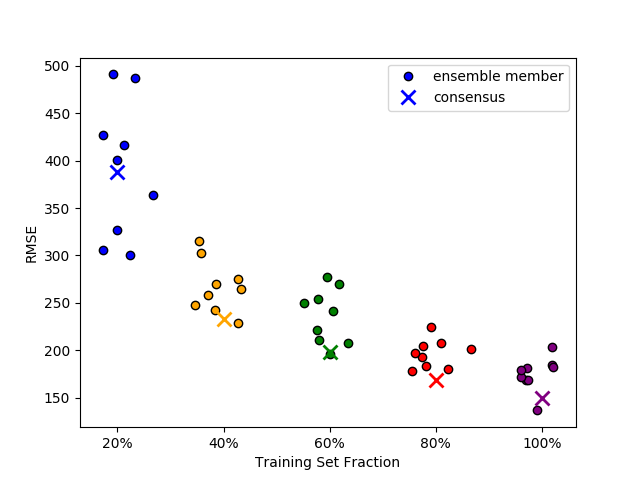

[491.04300213463716, 400.8591330810615, 416.6727796801269, 363.69817981068826, 306.1856500795568, 486.8399178769244, 426.84301758071786, 300.76701884603705, 326.7418349917038]
[315.1309507634746, 264.3881949011956, 228.2177848457335, 275.34454878369206, 257.90972678283873, 247.5323293792095, 302.3547802526744, 270.00299345657044, 242.35830496924237]
[220.79941338382494, 210.92302502939066, 196.43459021758179, 207.39796586166472, 277.04278827943057, 241.43213969325032, 249.86491858380137, 254.19271309370217, 269.9524763442279]
[180.20503735957186, 224.96019440972856, 178.07046066051228, 204.2805480011675, 192.82777399636146, 201.482227587265, 207.2058558423618, 197.40708040438744, 183.23796880444118]
[168.4346007910916, 184.64088693583938, 136.4473240179943, 168.00518255947722, 171.23512241703366, 181.12866041738192, 203.6691810730698, 179.16067745767774, 182.70145546856767]


In [18]:
plt.style.use("default")
props = [20,40,60,80,100]
colors = ["blue","orange","green","red","purple"]
ensemble = [i for i in range(9)]
fig,ax = plt.subplots()
for pi,p in enumerate(props):
    jit = np.random.randn(len(ensemble))*3
    vals = ensemble_rmses[p]
    ensvals = [vals[i] for i in ensemble]
    print(ensvals)
    if pi == 0:
        ax.plot([p+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],label = "ensemble member",markeredgecolor = "black")
        ax.plot(p,vals["median"],marker = "x",color=colors[pi],label = "consensus",markersize = 10,linestyle="None",markeredgewidth=2)
    else:
        ax.plot([p+jit[i] for i in ensemble],ensvals,marker = "o",linestyle = "None",color = colors[pi],markeredgecolor = "black")
        ax.plot(p,vals["median"],marker = "x",color=colors[pi],markersize = 10,linestyle = "None",markeredgewidth=2)
ax.set_ylabel("RMSE")
ax.set_xlabel("Training Set Fraction")
ax.set_xticks(props)
plt.legend(numpoints = 1)
ax.set_xticklabels(["{}%".format(pr) for pr in props])
plt.savefig("rmseplot_smoothmedian_same_seed_5_ericadata.png")

In [ ]:
# Now make a trace: 

In [23]:
prop = 100
ensemble = ensembles[prop]
pose_xy = ensemble.get_poses("b29_post_side_1min_labeled.mp4")
median_xy = mean_xy[100]
outmat = ensemble.models[0].get_groundtruth("/home/ubuntu/ensembledata_3/b29_post_side_1min_true_xy_all_1000pm_perm.mat")

<IPython.core.display.Javascript object>


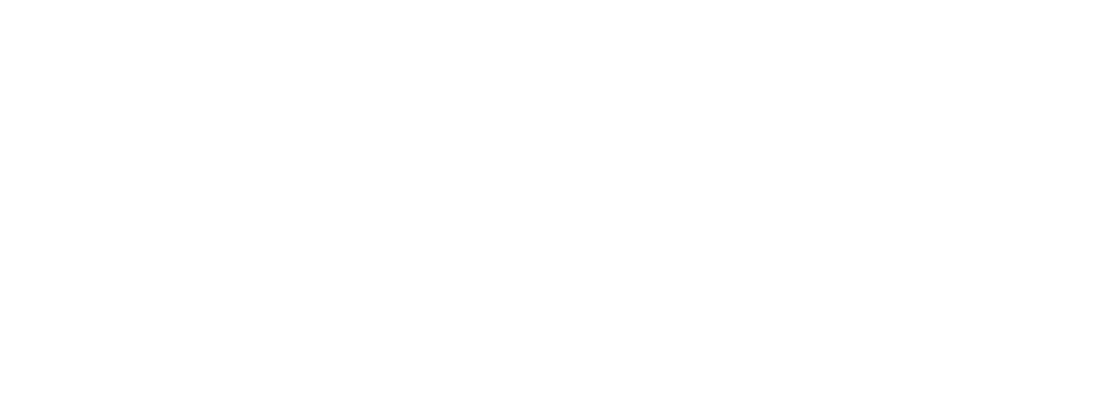

In [118]:
plt.style.use('dark_background')
fig,ax = plt.subplots(1,1,figsize = (11,4),sharex=True)
colors = dgp_ensembletools.models.colors[:-1]+dgp_ensembletools.models.colors
markers = dgp_ensembletools.models.markers
part_list = z["partindex"]
part = 0
cap = 1000
for xy in range(1,2):
    for i in range(9):
        ax.plot(pose_xy["run{}".format(i)][:cap,xy,part],label = "run {}".format(i),alpha = 0.7,color = "#0096FF")
        ax.plot(cap-1,pose_xy["run{}".format(i)][cap-1,xy,part],marker = markers[part],color = "#0096FF")
    ax.plot(median_xy[:cap,xy,part],label = "consensus",color = "orange")
    ax.plot(cap-1,median_xy[cap-1,xy,part],label = "consensus",color = "orange",marker = markers[part])
#ax.legend(prop={'size': 5})        
plt.suptitle("Ensemble and Consensus Trace for Right Ear".format(part_list[part]))
# ax[0].set_ylabel("y position (A.U.)")
ax.set_ylabel("x position (A.U.)")
ax.set_xlabel("frames")
plt.savefig("sample_traces_erica_data_simple")
# ax[1].axvline(x = 50)
# ax[0].axvline(x = 50)
plt.close("all")

<IPython.core.display.Javascript object>


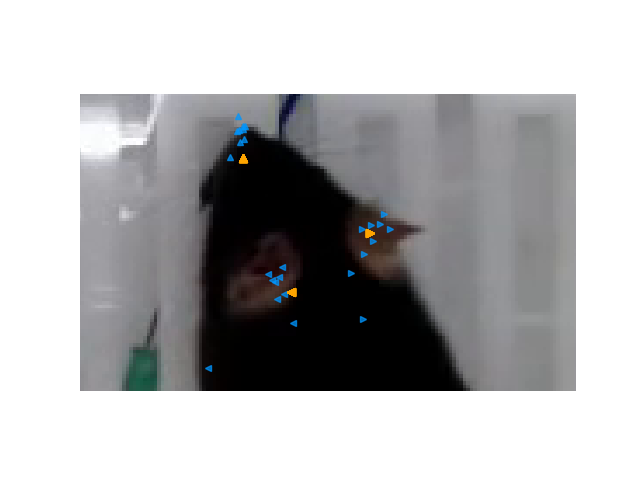

(-0.5, 639.5, 479.5, -0.5)

In [162]:
plt.style.use("default")
t = 960#500 keep#480#330#530
markers = ["<",">","^","+","P","8","*","X",2,3]
# colors = 
clip = VideoFileClip("/home/ubuntu/ensembledata_3/b29_post_side_1min.mp4")
# clip = ensemble.get_video_clip("b29_post_side_1min.mp4",frame_range = range(1001))
frame = clip.get_frame(t/clip.fps)
plt.imshow(frame)
for gtpart,part in enumerate([0,1,2,4,5,6,7,8,9]):
    for run in range(9):
        if run == 0 and gtpart == 2:
            runkwargs = {"label":"single model"}
            enskwargs = {"label":"ensemble"}
        else:
            runkwargs = {}
            enskwargs = {}
        xy = pose_xy["run{}".format(run)]
        plt.plot(*xy[t,:,part],"o",
                markersize = 4,
                marker = markers[gtpart],#"x",
                linestyle = "None",
                color = "#0096FF",
                alpha = 0.7,**runkwargs)
        plt.plot(*median_xy[t,:,part],"o",
                markersize = 6,
                marker = markers[gtpart],
                linestyle ="None",
                color = "orange",**enskwargs)
#         plt.plot(*outmat[t,:,gtpart],"o",
#                 markersize = 6,
#                 marker = "o",
#                 linestyle ="None",
#                 color = "blue")
# plt.legend()
plt.axis("off")
# plt.savefig("example_frame{}.png".format(t))        
# plt.close("all")

# characterize the error more carefully.

<IPython.core.display.Javascript object>


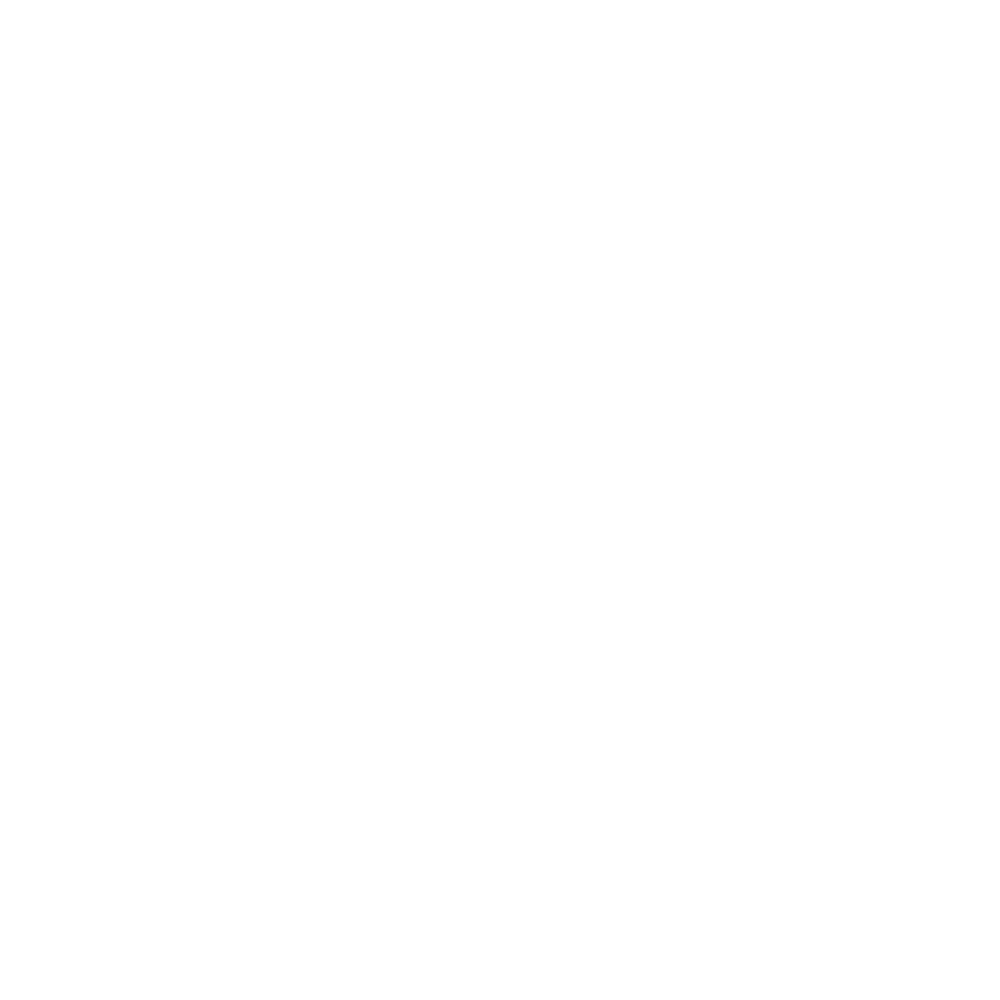

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


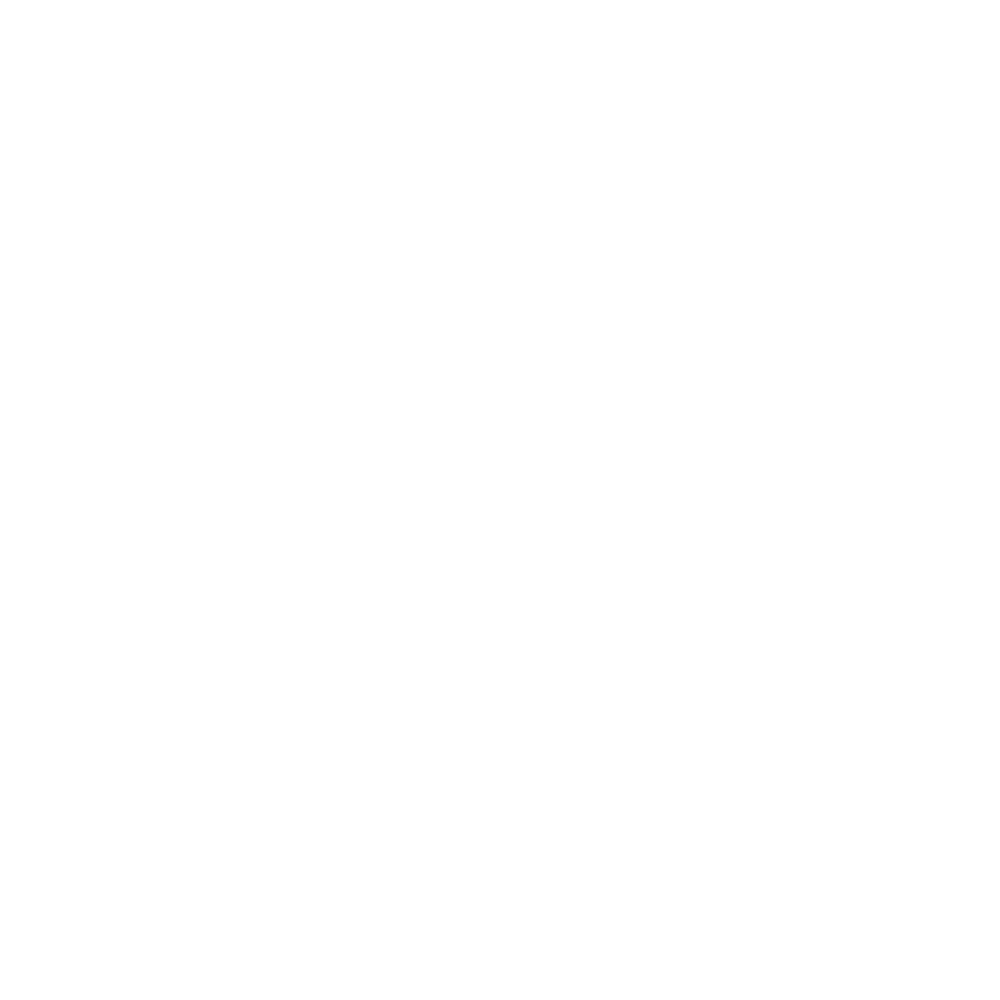

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


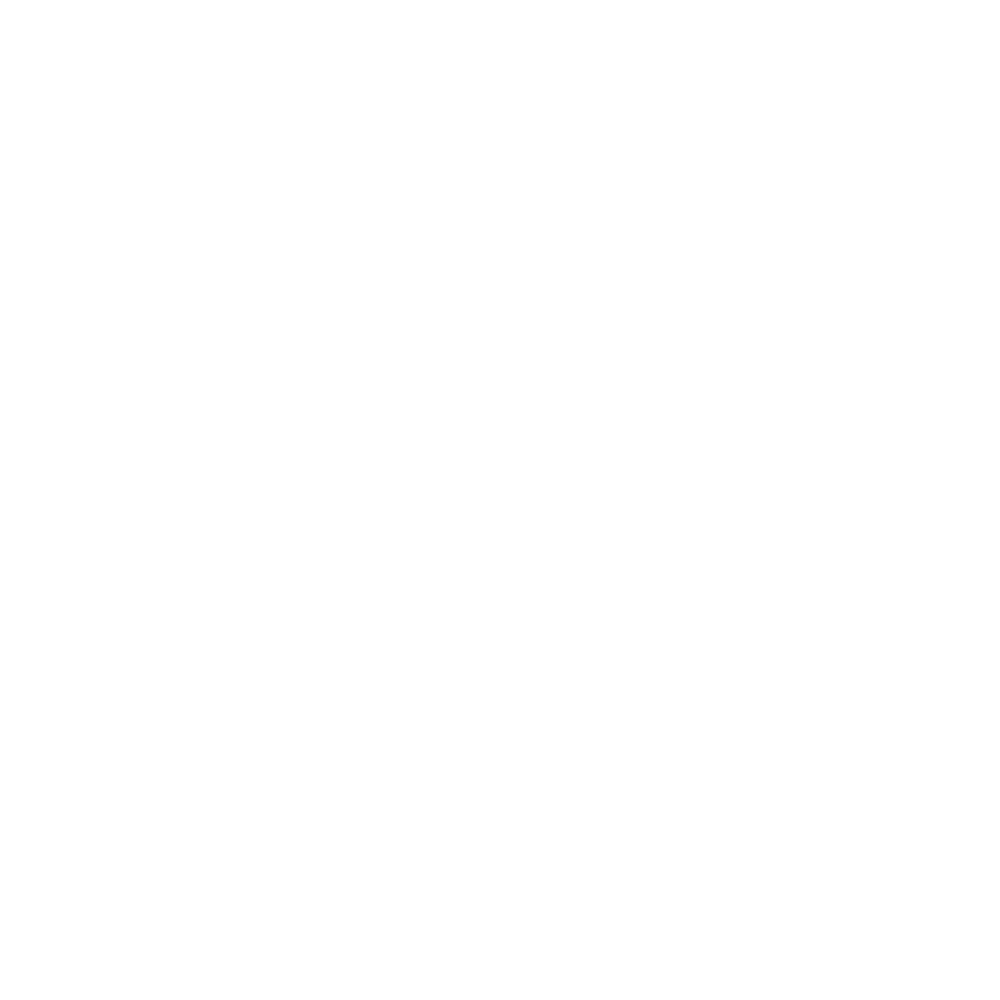

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


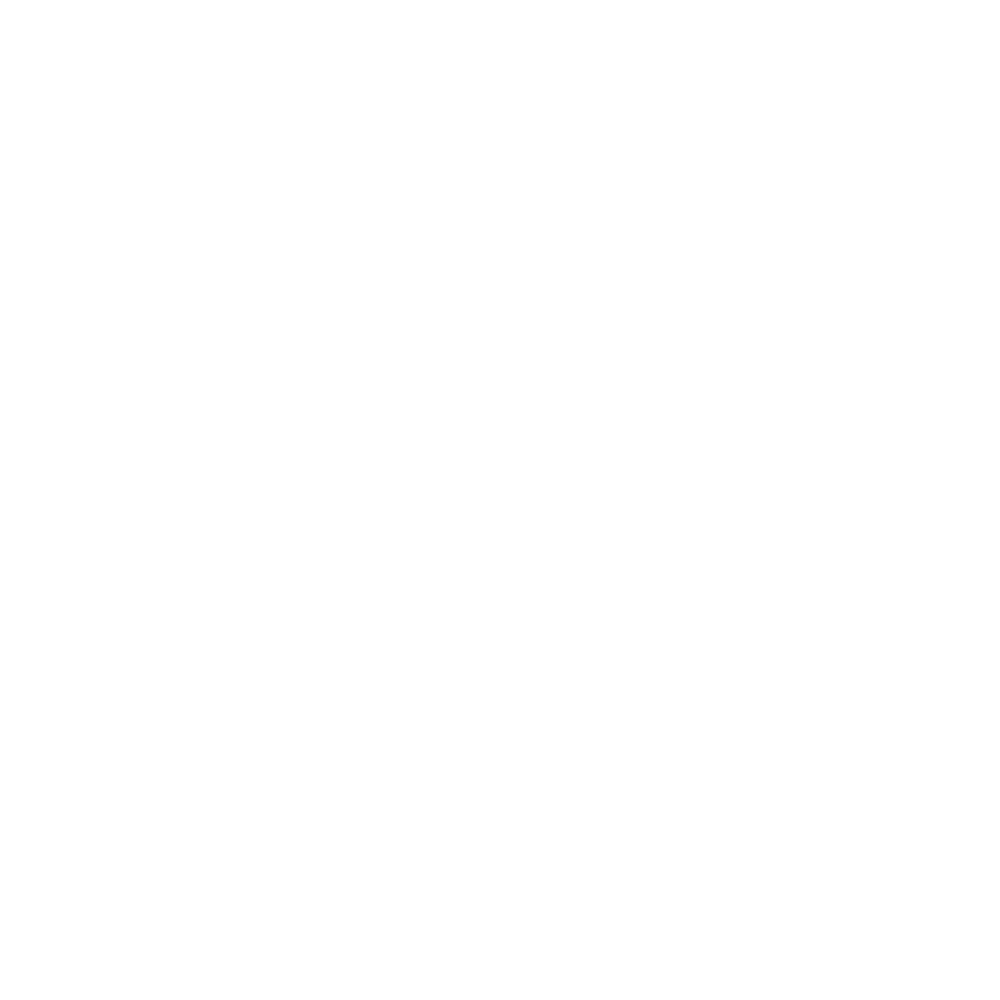

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


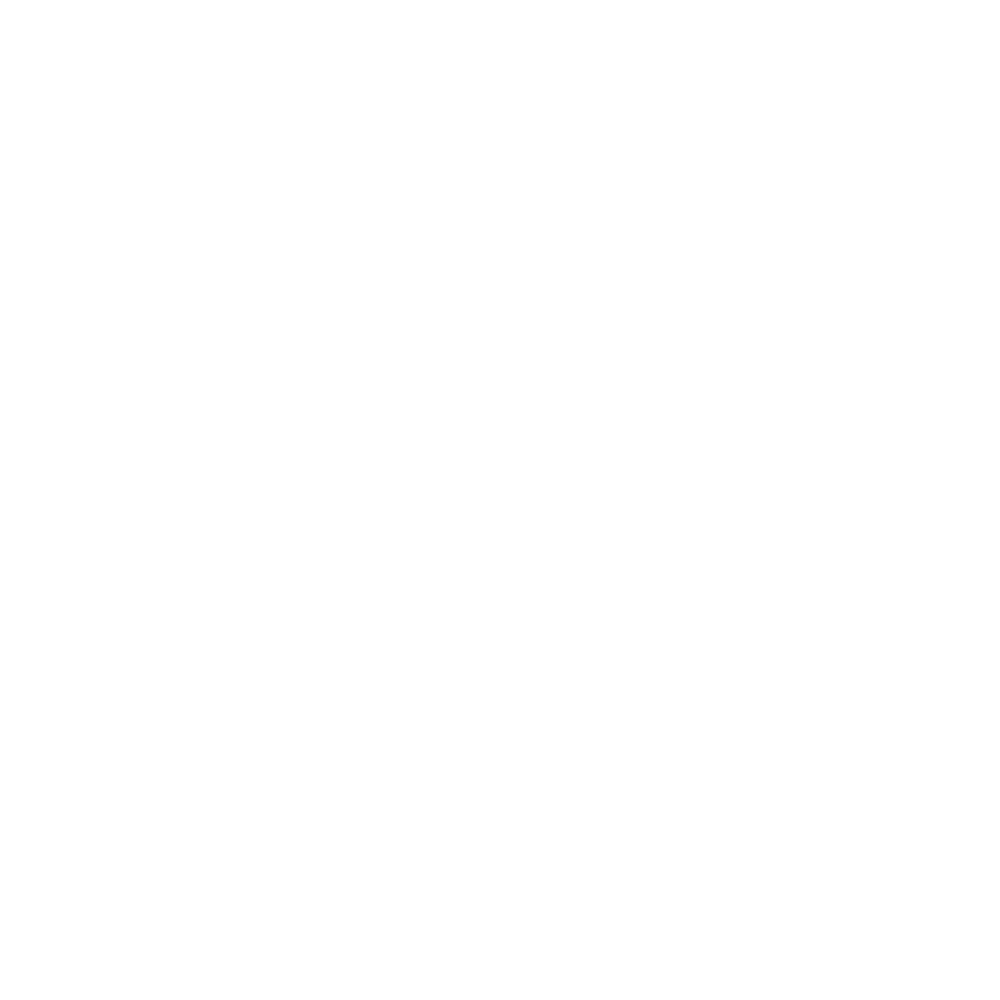

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


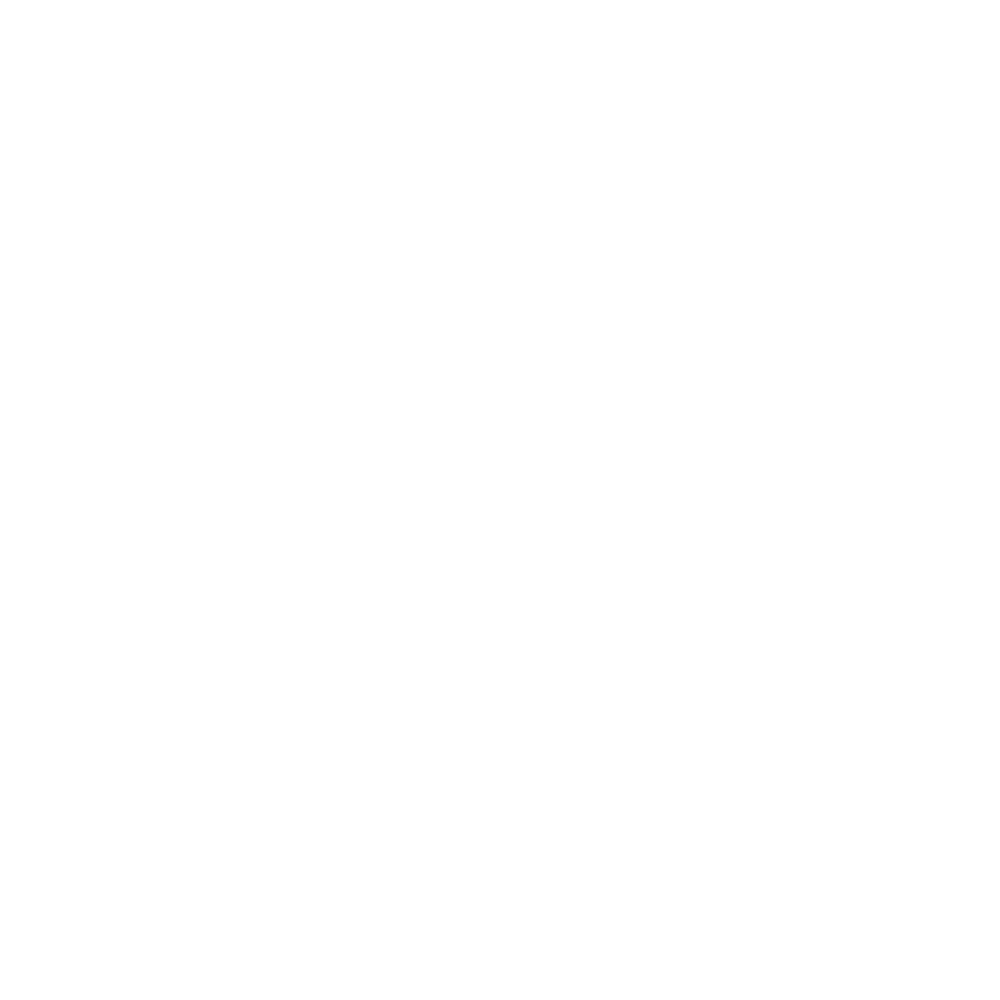

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


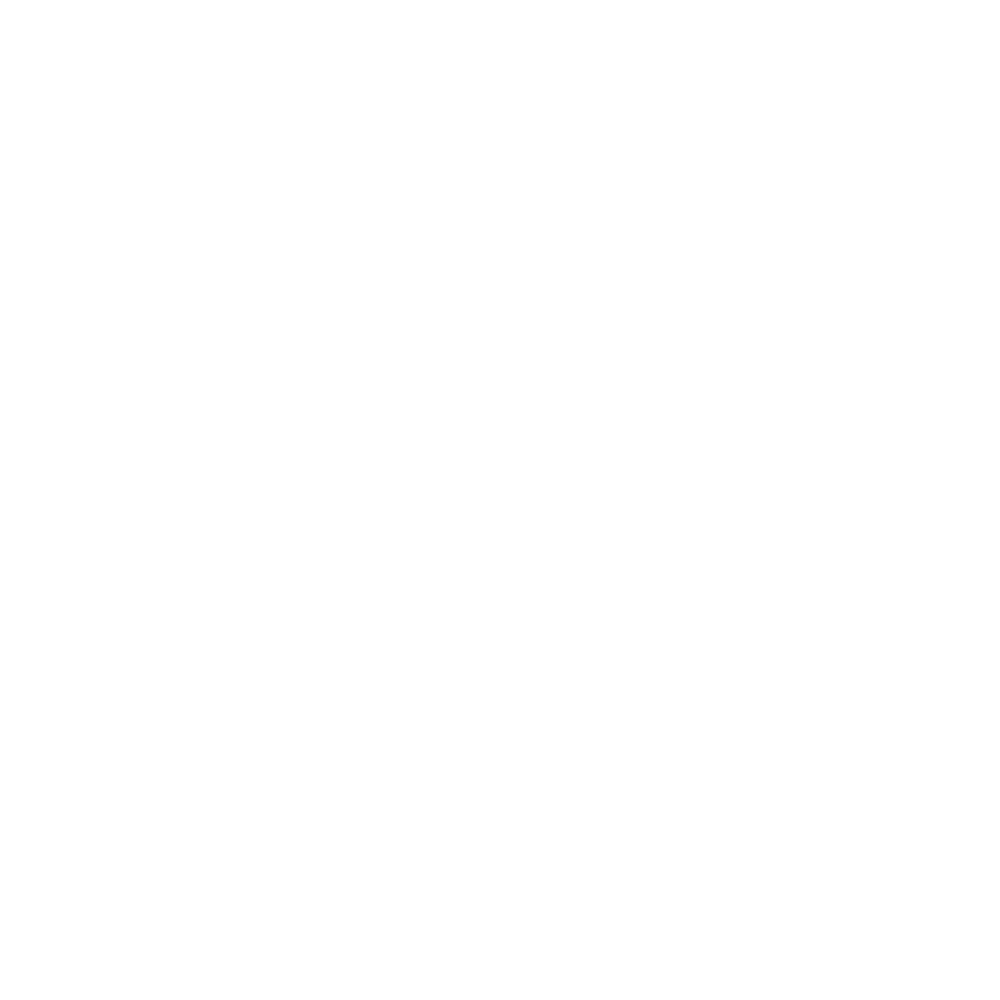

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


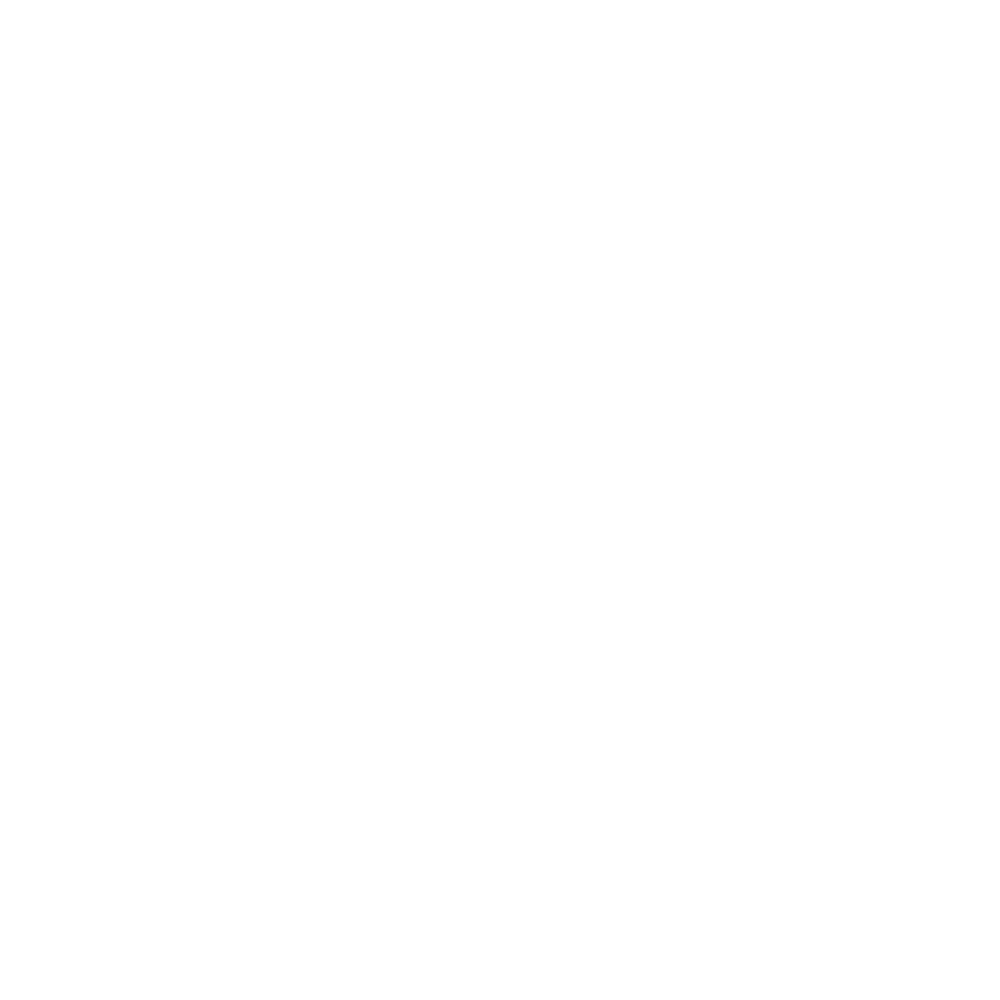

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


<IPython.core.display.Javascript object>


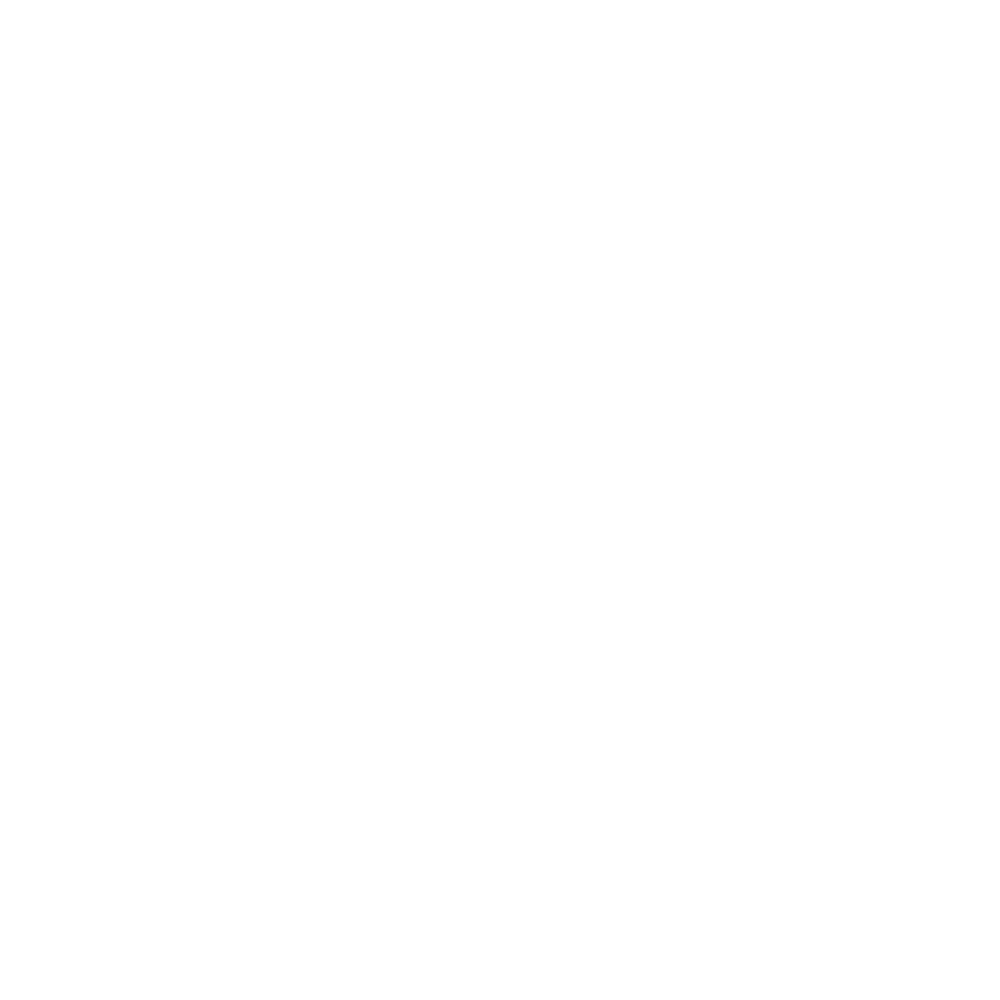

{'color': 'blue', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


{'color': 'blue', 'alpha': 0.5, 's': 10}


In [95]:
## Characterize the error more carefully. 
plt.style.use("default")
all_pose = ensemble.get_poses("b29_post_side_1min_labeled.mp4")

medpose_full = median_xy
runs = [i for i in range(9)]
for run in runs:
    fig,ax = plt.subplots(3,3,figsize = (10,10))
    part_list = z["partindex"]#["Right Pinky", "Right Ring", "Right Middle", "Right Pointer"]
    diff = all_pose[f"run{run}"][:1000,:,np.array([0,1,2,4,5,6,7,8,9,10])]-outmat
    consensusdiff = medpose_full[:1000,:,np.array([0,1,2,4,5,6,7,8,9,10])]-outmat
    for h in range(3):
        for w in range(3):
            part = h+w*3
            modkwargs = {"color":"#0096FF","alpha":0.5,"s":10}
            conkwargs = {"color":"orange","alpha":0.5,"s":10}
            if h == 0 and w == 0:
                modkwargs["label"] = "model"
                conkwargs["label"] = "consensus"
            print(modkwargs)
            ax[h,w].set_title("Error Distribution for {}".format(part_list[part]))
            ax[h,w].axvline(x=0,color = "black")
            ax[h,w].axhline(y=0,color = "black")
            #ax[h,w].scatter(*diff[:,:,part].T,color = "blue",alpha = 0.5,s =10)
            ax[h,w].scatter(*diff[:,:,part].T,**modkwargs)
            ax[h,w].scatter(*consensusdiff[:,:,part].T,**conkwargs)
            ax[h,w].legend()
            #ax[h,w].scatter(*consensusdiff[:,:,part].T,color = "orange",alpha = 0.5,s= 10)
            ax[h,w].axis("equal")
            ax[h,w].set_xlim([-300,300])
            ax[h,w].set_ylim([-300,300])
            ax[h,w].set_xlabel("pixels")
            ax[h,w].set_ylabel("pixels")
            plt.suptitle(f"Model {run}",y = 1.0)
            plt.tight_layout()
            
    plt.savefig("partwise_errordist_{}.png".format(run))
plt.close("all")

<IPython.core.display.Javascript object>


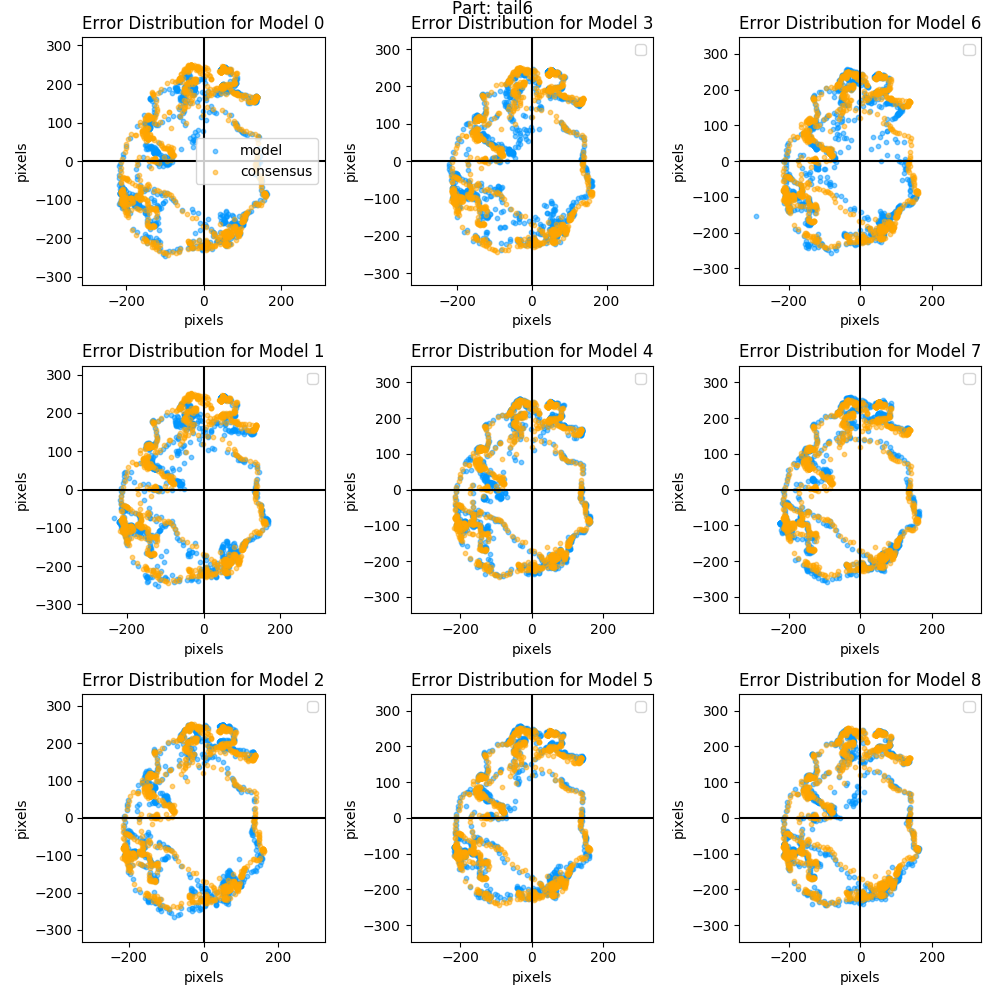

{'color': '#0096FF', 'alpha': 0.5, 's': 10, 'label': 'model'}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


{'color': '#0096FF', 'alpha': 0.5, 's': 10}


In [187]:
## Characterize the error more carefully: by model. 
plt.style.use("default")
all_pose = ensemble.get_poses("b29_post_side_1min_labeled.mp4")
partlist = [8]
medpose_full = median_xy
for gtpart,part in enumerate(partlist):
    fig,ax = plt.subplots(3,3,figsize = (10,10))
    runs = [i for i in range(9)]
    part_list = z["partindex"]#["Right Pinky", "Right Ring", "Right Middle", "Right Pointer"]

    for run in runs:
        diff = all_pose[f"run{run}"][:1000,:,np.array(partlist)]-outmat
        consensusdiff = medpose_full[:1000,:,np.array(partlist)]-outmat
        h = run%3
        w = run//3
#     for h in range(3):
#         for w in range(3):
#             part = h+w*3
        modkwargs = {"color":"#0096FF","alpha":0.5,"s":10}
        conkwargs = {"color":"orange","alpha":0.5,"s":10}
        if h == 0 and w == 0:
            modkwargs["label"] = "model"
            conkwargs["label"] = "consensus"
        print(modkwargs)
        ax[h,w].set_title("Error Distribution for Model {}".format(run))
        ax[h,w].axvline(x=0,color = "black")
        ax[h,w].axhline(y=0,color = "black")
        #ax[h,w].scatter(*diff[:,:,part].T,color = "blue",alpha = 0.5,s =10)
        ax[h,w].scatter(*diff[:,:,gtpart].T,**modkwargs)
        ax[h,w].scatter(*consensusdiff[:,:,gtpart].T,**conkwargs)
        ax[h,w].legend()
        #ax[h,w].scatter(*consensusdiff[:,:,part].T,color = "orange",alpha = 0.5,s= 10)
        ax[h,w].axis("equal")
        ax[h,w].set_xlim([-350,350])
        ax[h,w].set_ylim([-350,350])
        ax[h,w].set_xlabel("pixels")
        ax[h,w].set_ylabel("pixels")
        plt.suptitle(f"Part: {part_list[part]}",y = 1.0)
        plt.tight_layout()
            
    plt.savefig("modelwise_errordist_{}.png".format(part))
# plt.close("all")

In [ ]:
import deeplabcut.utils.auxiliaryfunctions as auxiliaryfunctions
from deepgraphpose.models.eval import load_pose_from_dlc_to_dict
from deepgraphpose.utils_model import get_train_config
from pathlib import Path
import os
from deepgraphpose.models.fitdgp_util import get_snapshot_path
import pandas as pd

In [ ]:
ls ../../ensembledata/job__ensemble-dgp_2_20_30p_real/1/videos_pred

In [ ]:
num_trains = 5
num_seeds = 9
#training_subsets = np.round(np.linspace(0.1,0.9, num_trains), 2)
training_subsets = {""}
training_seed = np.arange(1, num_seeds+1).astype('int')
ensemblepaths = {10:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_10p_real/process_results",
                 30:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_30p_real/process_results",
                 50:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_50p_real/process_results",
                 70:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_22_70p_real/process_results",
                 90:"/home/ubuntu/ensembledata/job__ensemble-dgp_2_20_90p_real"}
#%%
train_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
test_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
train_error_ensemble = np.zeros((num_trains,))*np.nan
test_error_ensemble = np.zeros((num_trains,))*np.nan
epsilon = 0
#nc = 200
ws_flag = None
#%%
task="ibl1"
scorer="kelly"
data_directory = "/home/ubuntu/ensembledata/"
training_subsets = {"job__ensemble-dgp_2_20_30p_real":10}


video_folder = ""
traces_folder = "videos_pred/{}_labeled.csv".format(task)
heatmaps_folder = "videos_pred/{}_labeled.npy".format(task)
shuffle=1
trainingsetindex=0
#%%
train_indices = [[]]*num_trains
test_indices = [[]]*num_trains
heatmap_indices = [[]]*num_trains
train_indices = {}
test_indices = {}
heatmap_indices = {}
skipped_seed = [[]]*num_trains
for train_fraction,ensemblepath in ensemblepaths.items():
    print("\n\n{}".format(train_fraction))
    heatmaps_files = []
    train_frames_ensemble = []
    test_frames_ensemble = []
    for seed_idx, seed in enumerate(training_seed):
        #date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}".format(ensemblepath)/"{}".format(seed))
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        cfg["project_path"] = os.path.join(data_directory,ensemblepath,str(seed))
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            skipped_seed[date_idx].append(seed_idx)
            continue
        # ------
        # get train/test sets (indices for video)
        trainingsetfolder = auxiliaryfunctions.GetTrainingSetFolder(cfg)
        datafn, metadatafn = auxiliaryfunctions.GetDataandMetaDataFilenames(
            trainingsetfolder, cfg['TrainingFraction'][trainingsetindex], shuffle, cfg)
        # Load meta data
        data, trainIndices, testIndices, trainFraction = auxiliaryfunctions.LoadMetadata(
            os.path.join(data_directory,ensemblepath,str(seed), metadatafn))
        # the train indices are the indices of the labeled frames? or the video itself
        # they are of the training set, so read the indices of the video
        Data = pd.read_hdf(os.path.join(data_directory,ensemblepath,str(seed), str(trainingsetfolder),
                                        'CollectedData_' + cfg["scorer"] + '.h5'),
                           'df_with_missing') #* dlc_cfg['global_scale']
        num_labels, _ = Data.values.shape
        labeled_frames = np.empty(num_labels).astype('int')
        for frame_idx in range(num_labels):
            idx_name = int(Path(Data.iloc[frame_idx].name).stem[3:])
            labeled_frames[frame_idx] = idx_name
        # Video frames user for training and testing:
        train_frames = labeled_frames[trainIndices]
        test_frames = labeled_frames[testIndices]
        # --- store confidence map to then calculate ensemble from heatmaps
        #last_snapshot, snapshot_data = get_last_snapshot(cfg_folder)
        last_snapshot = "snapshot-step2-final--0"
        assert "step2-final"  in last_snapshot
        print(cfg_folder.rsplit("/", 1)[-1], last_snapshot)
        # continue
        snapshot_path, cfg_yaml = get_snapshot_path(last_snapshot, cfg_folder,
                                                    shuffle=shuffle)
        #cfg = auxiliaryfunctions.read_config(cfg_yaml)
        video_file = Path(cfg_folder) / "videos/{}.mp4".format(task)
        video_pred_path = str(Path(cfg_folder) / 'videos_pred')
        print(snapshot_path)
#         _ = estimate_pose(
#                  proj_cfg_file=str(cfg_yaml),
#                  dgp_model_file=str(snapshot_path),
#                  video_file=str(video_file),
#                  output_dir=str(video_pred_path),
#                  shuffle=shuffle,
#                  save_str=last_snapshot,
#                  save_heatmap=True)
        heatmap_file = str(Path(cfg_folder) / heatmaps_folder)
        heatmaps_files.append(heatmap_file)
        train_frames_ensemble.append(train_frames)
        test_frames_ensemble.append(test_frames)
    # calculate ensemble loss using the heatmaps stored in npy labeled folder
    video_sets = list(cfg['video_sets'].keys())
    video_name = video_sets[0]
    cfg['video_path']=  Path(data_directory,ensemblepath,str(seed)) / video_name
    dlc_cfg = get_train_config(cfg, shuffle=shuffle)
    # train and test frames to use for ensemble
    train_indices[train_fraction] = train_frames_ensemble
    test_indices[train_fraction] = test_frames_ensemble 
    heatmap_indices[train_fraction] = heatmaps_files

In [ ]:
all_testframes = {}
for trainfrac in ensemblepaths:
    train_frames = np.unique(np.concatenate(train_indices[trainfrac]))
    test_frames = np.setdiff1d(np.arange(1000),train_frames).astype('int')
    all_testframes[trainfrac] = test_frames

In [ ]:
all_testframes

## Sanity check on the lower proportion events

In [ ]:
percent = 90
pose_xy = ensembles[percent].get_poses("ibl1_labeled.mp4")

In [ ]:
colors = ["red","blue","green","purple","magenta","yellow","brown","pink","blue"]
plt.style.use('dark_background')
fig,ax = plt.subplots(1,1,figsize = (11,4),sharex=True)
# colors = dgp_ensembletools.models.colors

markers = dgp_ensembletools.models.markers
part_list = ["Right Pinky", "Right Ring", "Right Middle", "Right Pointer"]
part = 2
cap = 1000
for xy in range(1,2):
    for i in range(9):
        ax.plot(pose_xy["run{}".format(i)][:cap,xy,part],label = "run {}".format(i),alpha = 0.7,color = colors[i])
        ax.plot(cap-1,pose_xy["run{}".format(i)][cap-1,xy,part],marker = markers[part],color = colors[i])
#     ax.plot(median_xy[:cap,xy,part],label = "consensus",color = colors[-1])
#     ax.plot(cap-1,median_xy[cap-1,xy,part],label = "consensus",color = colors[-1],marker = markers[part])
#ax.legend(prop={'size': 5})        
plt.suptitle("Ensemble and Consensus Trace for {}, {}% of training set".format(part_list[part],percent))
ax.set_ylabel("y position (A.U.)")
ax.set_xlabel("frames")
plt.savefig("sample_traces_fixed_seed_{}%".format(percent))

## 2/23 Run Kelly's code and reproduce her figs with your methods. 

In [ ]:
kellypath = "/home/ubuntu/ensembledata/kellydata10percent/copies"
ensemble = dgp_ensembletools.models.Ensemble(kellypath,[str(i+1) for i in range(6)],"mp4")

In [ ]:
rmse = ensemble.compare_groundtruth("ibl1_labeledsnapshot-step2-final--0.mp4",groundtruthpath = "/home/ubuntu/ibl1_true_xy_all_918pm.mat",
                             partperm=[1,3,0,2])

In [ ]:
print(rmse)

In [ ]:
ensemble_nb = 6
colors = "blue"
pi = 0
p = 0
jit = np.random.randn(ensemble_nb)*2
vals = rmse
ensvals = [vals[i] for i in range(ensemble_nb)]
print(ensvals)
fig,ax = plt.subplots()
ax.plot([p+jit[i] for i in range(ensemble_nb)],ensvals,marker = "o",linestyle = "None",color = colors[pi],label = "ensemble member",markeredgecolor = "black")
ax.plot(p,vals["median"],marker = "x",color=colors[pi],label = "consensus",markersize = 10,linestyle="None",markeredgewidth=2)

In [ ]:
a = np.array([[1,1,1],[2,2,2]])

In [ ]:
a[np.array([0])[:,None]].shape